In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from .../PycharmProjects.bvar.bvar.model import Bayesian Linear

In [2]:
full = pd.read_csv('growth_rate.csv', index_col=0, header=[0] ,parse_dates=True)
full.head() # unnormalised for now

,CPIAUCSL,FEDFUNDS,HOUST,INDPRO,INTDSRUSM193N,ISRATIO,M2SL,MTSDS133FMS,PAYEMS,PCE,...,CIVPART,GS20,GS3,IRLTLT01USM156N,M1SL,MCOILWTICO,PPIACO,TCU,TOTALSA,PMI
1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.479339,NaN,NaN,NaN
1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.666667,NaN,NaN,NaN
1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.500000,NaN,NaN,NaN
1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.500000,NaN,NaN,NaN
1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.521008,NaN,NaN,NaN


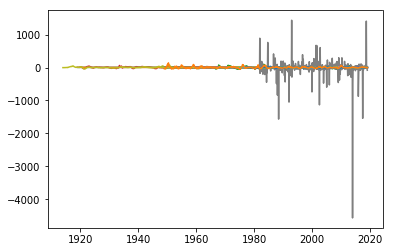

In [3]:
plt.plot(full)

In [4]:
# retain yoy
full.drop(columns=['A191RL1Q225SBEA'], inplace=True)

In [5]:
slice = full.loc["1960-01-01"].isna()

for i, v in slice.items():
    if v is True:
        print(i)

print(slice.value_counts())

ISRATIO
MTSDS133FMS
T10Y2YM
USSLIND
GFDEGDQ188S
MCOILWTICO
TCU
TOTALSA
False    23
True      8
Name: 1960-01-01 00:00:00, dtype: int64


In [6]:
sliced = full.loc["1960-01-01":"2019-01-01"]
sliced.shape

(709, 31)

In [7]:
# which ones are null? drop them

for series in sliced:
    col = sliced[series]
    if col.isna().value_counts().loc[False] < sliced.shape[0]:
        print(series)
        sliced = sliced.drop(columns=series)
        
sliced.shape

INTDSRUSM193N
ISRATIO
MTSDS133FMS
T10Y2YM
USSLIND
GFDEGDQ188S
GS20
MCOILWTICO
TCU
TOTALSA


(709, 21)

In [8]:
sliced.tail()

,CPIAUCSL,FEDFUNDS,HOUST,INDPRO,M2SL,PAYEMS,PCE,T10YFFM,UMCSENT,UNRATE,...,GPDI,PCEC,AAA,BAA,CIVPART,GS3,IRLTLT01USM156N,M1SL,PPIACO,PMI
2018-09-01,2.269315,1.95,6.276870,5.405756,3.705648,1.791863,4.717353,1.05,5.257624,3.7,...,9.192057,4.713233,3.98,4.88,-0.633914,2.84,3.00,3.620391,4.517454,-0.833333
2018-10-01,2.517164,2.19,-3.965107,4.059313,3.393570,1.800247,4.912073,0.96,-2.085402,3.8,...,9.438733,4.486011,4.14,5.07,0.318979,2.94,3.15,3.160784,4.976911,-1.541096
2018-11-01,2.194621,2.20,-7.467283,4.062132,3.295557,1.781281,4.709343,0.92,-1.015228,3.7,...,8.911112,4.352245,4.22,5.22,0.159236,2.91,3.12,1.914284,3.266973,1.906412
2018-12-01,1.945131,2.27,-6.316653,3.769242,3.724372,1.815090,3.841979,0.56,2.502607,3.9,...,8.393747,4.219135,4.02,5.13,0.637959,2.67,2.83,3.856589,2.394294,-8.585859
2019-01-01,1.522396,2.40,-3.295880,3.599663,4.107989,1.908410,3.970694,0.31,-4.702194,4.0,...,7.886342,4.086677,3.93,5.12,0.797448,2.52,2.71,2.496510,0.606367,-5.033557


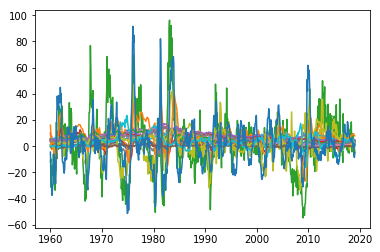

In [9]:
plt.plot(sliced)

In [10]:
def get_lags(X, lags):
    X_lagged = pd.DataFrame()

    for i in range(lags):
        temp = X.shift(i)
        X_lagged = pd.concat([X_lagged, temp], axis=1)

    return X_lagged


In [11]:
n = sliced.shape[1] # num of series
lags = 3
k = lags * n + 1

In [12]:
X_lagged = get_lags(sliced, lags)
X_lagged.shape

(709, 63)

In [13]:
y = sliced
X = np.concatenate((np.ones((y.shape[0], 1)), X_lagged), axis=1)
print(y.shape)
print(X.shape)

(709, 21)
(709, 64)


In [14]:
y = y[lags:]
X = X[lags:]
print(y.shape) # t * n
print(X.shape) # t * k

(706, 21)
(706, 64)


In [15]:
t = y.shape[0] # time periods

In [23]:
for i in range(n):
    temp = np.zeros((k, 1))
    temp[i + 1] = 1
    if i == 0:
        b_0 = temp.T
    else:
        b_0 = np.concatenate((b_0, temp.T), axis=1)

print(b_0.shape) # which is 21 * 64

(1, 1344)


In [24]:
b_0 = b_0.T
print(b_0.shape)

(1344, 1)


In [22]:
from scipy.linalg import lstsq

coef, _, _, _ = lstsq(X, y)
error = y - np.dot(X, coef)
sse = np.dot(error.T, error)
# var = sse / (n - k)
sigma = (1 / (y.shape[0] - X.shape[1])) * sse

print(coef.shape) # k * n
print(sigma.shape)

(64, 21)
(21, 21)


In [20]:
np.linalg.cond(np.matmul(X.T, X)) # extremely ill conditioned...

2.3648953218832003e+17